<a href="https://colab.research.google.com/github/sithot28/Two_Stage_Encoder/blob/main/final_model_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_addons
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, InputLayer, Input, Lambda, PReLU, MaxPool1D, Flatten, Concatenate, MaxPool2D, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, BatchNormalization, ReLU, Softmax, Multiply, Add, Reshape, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow_addons.layers import InstanceNormalization

import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 33.9 MB/s 


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.utils import class_weight

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [ ]:
mx = MinMaxScaler()
sc = StandardScaler()
smt = SMOTE()
rus = RandomUnderSampler()
lbl = LabelEncoder()

# Dataset preprocessing

Load dataset. 

DS1 = train_dataset from record number:  101, 106, 108, 109, 112, 114, 115,116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215,220, 223,230

DS2 = test_dataset from record number:100, 103, 105, 11, 113, 117, 121, 123, 200, 202, 210, 212, 213,214, 219, 221, 222, 228, 231, 232,234

In [ ]:
train_dataset = pd.read_csv('drive/MyDrive/Kuliah/thesis/datasets/train_rr_record_187.csv', header=None)
test_dataset = pd.read_csv('drive/MyDrive/Kuliah/thesis/datasets/test_rr_record_187.csv', header=None)

train_dataset.head(3)

,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
0,101,0,315,321,0.489697,0.490856,0.494314,0.494324,0.492034,0.493193,...,0.500011,0.504638,0.502366,0.502394,0.504721,0.507049,0.511676,0.517453,0.517481,0.515210
1,101,0,321,336,0.483706,0.484887,0.480319,0.474601,0.475783,0.480413,...,0.476228,0.480852,0.486626,0.486651,0.482077,0.486701,0.489026,0.494800,0.498274,0.501748
2,101,0,336,344,0.477125,0.474840,0.472556,0.474870,0.477184,0.479498,...,0.486274,0.488586,0.492048,0.494360,0.492072,0.494384,0.495547,0.501308,0.504770,0.505932


Clean dataset from R-R peak more than 2s, anterior 0 and posterior 0

In [ ]:
#Clean dataset with R to R peak more than n_remove points

n_remove = 720

train_dataset = train_dataset.loc[train_dataset[2]<=n_remove]
train_dataset = train_dataset.loc[train_dataset[3]<=n_remove]

test_dataset = test_dataset.loc[test_dataset[2]<=n_remove]
test_dataset = test_dataset.loc[test_dataset[3]<=n_remove]

train_dataset = train_dataset.loc[(train_dataset[2] != 0) & (train_dataset[3] != 0)]
test_dataset = test_dataset.loc[(test_dataset[2] != 0) & (test_dataset[3] != 0)]

In [ ]:
# train_dataset = train_dataset.loc[(train_dataset[2] != 0) & (train_dataset[3] != 0)]
# test_dataset = test_dataset.loc[(test_dataset[2] != 0) & (test_dataset[3] != 0)]

Heartbeat type Q(5) not evaluated in this study, unclassified beat. Meanwhile, number of sample type (4), for both training and testing very small, so we also remove from dataset

In [ ]:
train_dataset = train_dataset[(train_dataset[1] != 4) & (train_dataset[1] != 5)]
test_dataset = test_dataset[(test_dataset[1] != 4) & (test_dataset[1] != 5)]

In [ ]:
train_dataset.shape, test_dataset.shape

((50904, 191), (49431, 191))

Split dataset into two groups:
 - Group 0, contains datataset of class N(0) and S(1)
 - Group 1, contains dataset of class V(2) and F(3

In [ ]:
train_dataset['group'] = train_dataset[1].apply(lambda x: 0 if x in [0, 1] else 1)

test_dataset['group'] = test_dataset[1].apply(lambda x: 0 if x in [0, 1] else 1)


Calculate avg Anterior and Posterior of every beat. 
*   Insert column avg_pre : average of R-R of anterior for every patient
*   Insert column avg_post : average of R-R of posterior for every patient

Other paper, used overall train data and test data to construct features, for example average of Anterior / Posterior of all patients, which is not feasible in realtime classification scenario


In [ ]:
avg = train_dataset.iloc[:, 0:4].groupby(0).mean().to_dict()
avg_pre = avg[2]
avg_post = avg[3]
train_dataset['avg_pre'] = train_dataset[0].map(avg_pre)
train_dataset['avg_post'] = train_dataset[0].map(avg_post)

avg = test_dataset.iloc[:, 0:4].groupby(0).mean().to_dict()
avg_pre = avg[2]
avg_post = avg[3]
test_dataset['avg_pre'] = test_dataset[0].map(avg_pre) #average per record
test_dataset['avg_post'] = test_dataset[0].map(avg_post) #average per record

Calculate other feature per patient, e.g average of average anterior and posterior, ratio between anterior with posterior and also ratio between pre_post with average of patient

In [ ]:
train_dataset['avg'] = (train_dataset['avg_pre'] + train_dataset['avg_post']) / 2   #average per record
test_dataset['avg'] = (test_dataset['avg_pre'] + test_dataset['avg_post']) / 2

train_dataset['avg_pre_post'] = train_dataset['avg_pre'] / train_dataset['avg_post']
test_dataset['avg_pre_post'] = test_dataset['avg_pre'] / test_dataset['avg_post']

train_dataset['pre_post'] = train_dataset[2] / train_dataset[3]
test_dataset['pre_post'] = test_dataset[2] / test_dataset[3]

train_dataset['ratio'] = train_dataset['pre_post'] / train_dataset['avg_pre_post'] 
test_dataset['ratio'] = test_dataset['pre_post'] / test_dataset['avg_pre_post']

Work with related dataframe, N-S and V-F

In [ ]:
dt_train1 = train_dataset[(train_dataset[1] == 0) | (train_dataset[1]==1)]
dt_train2 = train_dataset[(train_dataset[1] == 2) | (train_dataset[1]==3)]

dt_test1 = test_dataset[(test_dataset[1] == 0) | (test_dataset[1]==1)]
dt_test2 = test_dataset[(test_dataset[1] == 2) | (test_dataset[1]==3)]


In [ ]:
dt_train1.shape, dt_train2.shape, dt_test1.shape, dt_test2.shape

((46708, 198), (4196, 198), (45824, 198), (3607, 198))

Prepare data for NN models

Train data and Test data of group N-S, group V-F, NS, and VF



> Signal data taken from dataset index 4 to 190

> RR-Features taken from dataset index 2, 3, 191, 192, 193, 194, 195, 196, 197





In [ ]:
dt_train1.head(3)

,0,1,2,3,4,5,6,7,8,9,...,188,189,190,group,avg_pre,avg_post,avg,avg_pre_post,pre_post,ratio
0,101,0,315,321,0.489697,0.490856,0.494314,0.494324,0.492034,0.493193,...,0.517453,0.517481,0.515210,0,348.515054,348.569355,348.542204,0.999844,0.981308,0.981461
1,101,0,321,336,0.483706,0.484887,0.480319,0.474601,0.475783,0.480413,...,0.494800,0.498274,0.501748,0,348.515054,348.569355,348.542204,0.999844,0.955357,0.955506
2,101,0,336,344,0.477125,0.474840,0.472556,0.474870,0.477184,0.479498,...,0.501308,0.504770,0.505932,0,348.515054,348.569355,348.542204,0.999844,0.976744,0.976896


In [ ]:
X_train0 = train_dataset.iloc[:, 4:191].to_numpy().astype(float)
X_test0 = test_dataset.iloc[:, 4:191].to_numpy().astype(float)

y_train0 = train_dataset.loc[:,'group'].to_numpy().astype(int)
y_test0 = test_dataset.loc[:,'group'].to_numpy().astype(int)

In [ ]:
features_train0 = train_dataset.iloc[:, [2, 3, 192, 193, 194, 195, 196, 197]].to_numpy().astype(float)
features_test0 = test_dataset.iloc[:, [2, 3, 192, 193, 194, 195, 196, 197]].to_numpy().astype(float)

In [ ]:
X_train1 = dt_train1.iloc[:, 4:191].to_numpy().astype(float)
X_test1 = dt_test1.iloc[:, 4:191].to_numpy().astype(float)

y_train1 = dt_train1.loc[:,1].to_numpy().astype(int)
y_test1 = dt_test1.loc[:, 1].to_numpy().astype(int)

In [ ]:
features_train1 = dt_train1.iloc[:, [2, 3, 192, 193, 194, 195, 196, 197]].to_numpy().astype(float)
features_test1 = dt_test1.iloc[:, [2, 3, 192, 193, 194, 195, 196, 197]].to_numpy().astype(float)

In [ ]:
X_train2 = dt_train2.iloc[:, 4:191].to_numpy().astype(float)
X_test2 = dt_test2.iloc[:, 4:191].to_numpy().astype(float)

y_train2 = dt_train2.loc[:,1].to_numpy().astype(int)
y_test2 = dt_test2.loc[:, 1].to_numpy().astype(int)

In [ ]:
features_train2 = dt_train2.iloc[:, [2, 3, 192, 193, 194, 195, 196, 197]].to_numpy().astype(float)
features_test2 = dt_test2.iloc[:, [2, 3, 192, 193, 194, 195, 196, 197]].to_numpy().astype(float)

In [ ]:
X_train0.shape, X_train1.shape, X_train2.shape, features_train0.shape, features_train1.shape, features_train2.shape

((50904, 187), (46708, 187), (4196, 187), (50904, 8), (46708, 8), (4196, 8))

In [ ]:
#Lets scale the features data
features_train0 = mx.fit_transform(features_train0)
features_test0 = mx.fit_transform(features_test0)

features_train1 = mx.fit_transform(features_train1)
features_test1 = mx.fit_transform(features_test1)

features_train2 = mx.fit_transform(features_train2)
features_test2 = mx.fit_transform(features_test2)



Utility function

In [ ]:
def reshape(x):
    return x.reshape(x.shape[0], x.shape[1], 1)

def get_class(x):
    return np.unique(x, return_counts=True)    

Function to plot train history

In [ ]:
def plot_history(history, title):
  plt.figure(figsize=(10, 4))
  plt.plot(history.history['sparse_categorical_accuracy'], label='Train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], label='Val')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title('Sparse Categorical Accuracy '+title)
  plt.show()
  
  plt.figure(figsize=(10, 4))
  plt.plot(history.history['loss'], label='Train')
  plt.plot(history.history['val_loss'], label='Val')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Loss '+title)
  plt.show()

# Define Network Archicture

Multi layer perceptron.

In [ ]:
def make_MLP(input_shape, num_class):    
    model = Sequential()    
    model.add(InputLayer(input_shape=input_shape))
    model.add(Dropout(0.1))
    
    model.add(Dense(500))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(500))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
              
    model.add(Dense(500))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
              
    model.add(Dense(num_class))
    model.add(Activation('sigmoid'))    

    return model

Modified Encoder

In [ ]:
#original model use dropout 1-3: 0.2, change to 0.3, 0.35, 0.3

In [ ]:
def make_Modif_Encoder(input_shape, features_size, num_class):
    inp_layer = Input(shape=input_shape)
    inp_rr = Input(shape=features_size)
    
    #block-1
    conv1 = Conv1D(filters=128, kernel_size=5, strides=1, padding='same')(inp_layer)
    conv1 = InstanceNormalization()(conv1)
    conv1 = PReLU(shared_axes=[1])(conv1)
    conv1 = Dropout(rate=0.3)(conv1)
    conv1 = MaxPool1D(pool_size=2)(conv1)
    
    #block-2
    conv2 = Conv1D(filters=256, kernel_size=11, strides=1, padding='same')(conv1)
    conv2 = InstanceNormalization()(conv2)
    conv2 = PReLU(shared_axes=[1])(conv2)
    conv2 = Dropout(rate=0.35)(conv2)
    conv2 = MaxPool1D(pool_size=2)(conv2)
    
    #block-3
    conv3 = Conv1D(filters=512, kernel_size=21, strides=1, padding='same')(conv2)
    conv3 = InstanceNormalization()(conv3)
    conv3 = PReLU(shared_axes=[1])(conv3)
    conv3 = Dropout(rate=0.3)(conv3)

    #block-4 split for attention
    attention_data =    Lambda(lambda x: x[:, :, :])(conv3)
    attention_softmax = Lambda(lambda x: x[:, :, :])(conv3)
    
    #attention mechanisme
    attention_softmax = Softmax()(attention_softmax)
    multiply_layer = Multiply()([attention_softmax, attention_data])    
    
    #Last layer
    dense_layer = Dense(units=256, activation='sigmoid')(multiply_layer)
    # dense_layer = InstanceNormalization()(dense_layer)

    dense_layer = GlobalAveragePooling1D()(dense_layer)

    rr_layer = Concatenate()([dense_layer, inp_rr])
    rr_layer = Dense(128, activation='sigmoid')(rr_layer)

    
    #output layer
    flatten_layer = Flatten()(rr_layer)
    output_layer = Dense(units=num_class, activation='softmax')(flatten_layer)
    
    return tf.keras.models.Model(inputs = [inp_layer, inp_rr], outputs=output_layer)
    

In [ ]:
def make_Modif_Encoder2(input_shape, features_size, num_class):
    inp_layer = Input(shape=input_shape)
    inp_rr = Input(shape=features_size)
    
    #block-1
    conv1 = Conv1D(filters=128, kernel_size=5, strides=1, padding='same')(inp_layer)
    conv1 = InstanceNormalization()(conv1)
    conv1 = PReLU(shared_axes=[1])(conv1)
    conv1 = Dropout(rate=0.2)(conv1)
    conv1 = MaxPool1D(pool_size=2)(conv1)
    
    #block-2
    conv2 = Conv1D(filters=256, kernel_size=11, strides=1, padding='same')(conv1)
    conv2 = InstanceNormalization()(conv2)
    conv2 = PReLU(shared_axes=[1])(conv2)
    conv2 = Dropout(rate=0.2)(conv2)
    conv2 = MaxPool1D(pool_size=2)(conv2)
    
    #block-3
    conv3 = Conv1D(filters=512, kernel_size=21, strides=1, padding='same')(conv2)
    conv3 = InstanceNormalization()(conv3)
    conv3 = PReLU(shared_axes=[1])(conv3)
    conv3 = Dropout(rate=0.2)(conv3)

    #block-4 split for attention
    attention_data =    Lambda(lambda x: x[:, :, :256])(conv3)
    attention_softmax = Lambda(lambda x: x[:, :, 256:])(conv3)
    
    #attention mechanisme
    attention_softmax = Softmax()(attention_softmax)
    multiply_layer = Multiply()([attention_softmax, attention_data])    
    
    #Last layer
    dense_layer = Dense(units=256, activation='sigmoid')(multiply_layer)
    # dense_layer = InstanceNormalization()(dense_layer)

    dense_layer = GlobalAveragePooling1D()(dense_layer)

    rr_layer = Concatenate()([dense_layer, inp_rr])
    rr_layer = Dense(128, activation='sigmoid')(rr_layer)

    
    #output layer
    flatten_layer = Flatten()(rr_layer)
    output_layer = Dense(units=num_class, activation='softmax')(flatten_layer)
    
    return tf.keras.models.Model(inputs = [inp_layer, inp_rr], outputs=output_layer)
    

Original Encoder

In [ ]:
def make_Encoder(input_shape, features_size, num_class):
    inp_layer = Input(shape=input_shape)
    inp_rr = Input(shape=features_size)
    
    #block-1
    conv1 = Conv1D(filters=128, kernel_size=5, strides=1, padding='same')(inp_layer)
    conv1 = InstanceNormalization()(conv1)
    conv1 = PReLU(shared_axes=[1])(conv1)
    conv1 = Dropout(rate=0.2)(conv1)
    conv1 = MaxPool1D(pool_size=2)(conv1)
    
    #block-2
    conv2 = Conv1D(filters=256, kernel_size=11, strides=1, padding='same')(conv1)
    conv2 = InstanceNormalization()(conv2)
    conv2 = PReLU(shared_axes=[1])(conv2)
    conv2 = Dropout(rate=0.2)(conv2)
    conv2 = MaxPool1D(pool_size=2)(conv2)
    
    #block-3
    conv3 = Conv1D(filters=512, kernel_size=21, strides=1, padding='same')(conv2)
    conv3 = InstanceNormalization()(conv3)
    conv3 = PReLU(shared_axes=[1])(conv3)
    conv3 = Dropout(rate=0.2)(conv3)

    #block-4 split for attention
    attention_data =    Lambda(lambda x: x[:, :, :256])(conv3)
    attention_softmax = Lambda(lambda x: x[:, :, 256:])(conv3)
    
    #attention mechanisme
    attention_softmax = Softmax()(attention_softmax)
    multiply_layer = Multiply()([attention_softmax, attention_data])    
    
    #Last layer
    dense_layer = Dense(units=256, activation='sigmoid')(multiply_layer)
    # dense_layer = InstanceNormalization()(dense_layer)

    dense_layer = GlobalAveragePooling1D()(dense_layer)

    rr_layer = Concatenate()([dense_layer, inp_rr])
    rr_layer = Dense(128, activation='sigmoid')(rr_layer)

    
    #output layer
    flatten_layer = Flatten()(rr_layer)
    output_layer = Dense(units=num_class, activation='softmax')(flatten_layer)
    
    return tf.keras.models.Model(inputs = [inp_layer, inp_rr], outputs=output_layer)
    

In [ ]:
tf.keras.utils.plot_model(model_0, show_shapes=True)

# Train and Evaluate the Network

Classifier-0 : to classify N-S and V-F group

In [ ]:
# xx = X_train2.reshape(X_train2.shape[0], X_train2.shape[1])
print(X_train0.shape)
print(features_train0.shape)
xx = X_train0
my_x = np.concatenate([xx, features_train0], axis=1)
my_x, y_train0 = smt.fit_resample(my_x, y_train0)
my_x.shape, y_train0.shape

(50904, 187)
(50904, 8)


((93416, 195), (93416,))

In [ ]:
# my_x.shape
X_train0 = my_x[:, :-8]
features_train0 = my_x[:, -8:]
X_train0.shape, features_train0.shape

((93416, 187), (93416, 8))

In [ ]:
# idx = np.random.permutation(len(X_train0))
# X_train0 = X_train0[idx]
# features_train0 = features_train0[idx]

num_class = len(np.unique(y_train0))
features_size = features_train0.shape[1]
X_train = X_train0.reshape(X_train0.shape[0], X_train0.shape[1], 1)

model_0 = make_Modif_Encoder(X_train.shape[1:], features_size, num_class)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model_0.h5", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=25, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, verbose=1),
]

model_0.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])


In [ ]:
batch_size = 64
epochs = 500
history = model_0.fit(
    [X_train, features_train0],
    y_train0,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,    
    verbose=1,
)

Epoch 1/500
1168/1168 [==============================] - 35s 27ms/step - loss: 0.0641 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.0378 - val_sparse_categorical_accuracy: 0.9930 - lr: 0.0010
Epoch 2/500
1168/1168 [==============================] - 32s 27ms/step - loss: 0.0137 - sparse_categorical_accuracy: 0.9952 - val_loss: 0.0799 - val_sparse_categorical_accuracy: 0.9755 - lr: 0.0010
Epoch 3/500
1168/1168 [==============================] - 32s 27ms/step - loss: 0.0090 - sparse_categorical_accuracy: 0.9967 - val_loss: 0.0304 - val_sparse_categorical_accuracy: 0.9889 - lr: 0.0010
Epoch 4/500
1168/1168 [==============================] - 31s 27ms/step - loss: 0.0079 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.0448 - val_sparse_categorical_accuracy: 0.9866 - lr: 0.0010
Epoch 5/500
1168/1168 [==============================] - 32s 27ms/step - loss: 0.0059 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.0197 - val_sparse_categorical_accuracy: 0.9938 - lr: 0.0010
Epoch 6/50

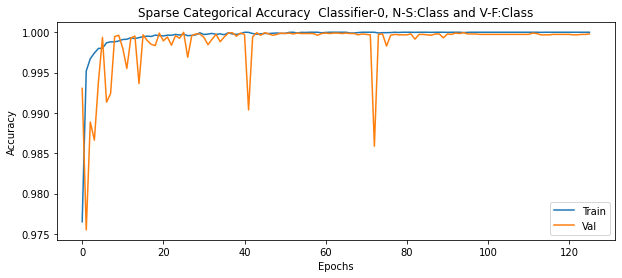

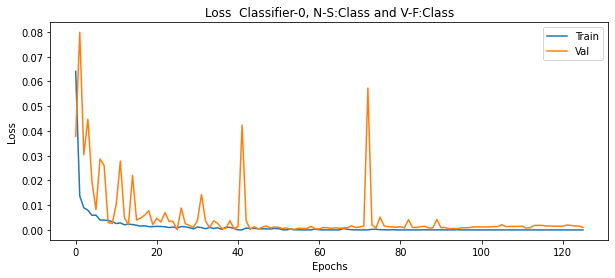

In [ ]:
plot_history(history,' Classifier-0, N-S:Class and V-F:Class')

In [ ]:
X_test = X_test0.reshape(X_test0.shape[0], X_test0.shape[1], 1)

model_0.load_weights('best_model_0.h5')
y_pred = model_0.predict([X_test, features_test0])
y_pred = np.argmax(y_pred, axis=1)

1545/1545 [==============================] - 9s 6ms/step


In [ ]:
np.unique(y_train0, return_counts=True)

(array([0, 1]), array([46708, 46708]))

In [ ]:
print('Classifier-0 : ')
print(confusion_matrix(y_test0, y_pred))
print(classification_report(y_test0, y_pred, digits=4))

Classifier-0 : 
[[37569  8255]
 [  194  3413]]
              precision    recall  f1-score   support

           0     0.9949    0.8199    0.8989     45824
           1     0.2925    0.9462    0.4469      3607

    accuracy                         0.8291     49431
   macro avg     0.6437    0.8830    0.6729     49431
weighted avg     0.9436    0.8291    0.8659     49431



Classifier-1: to classify N and S class


In [ ]:
# xx = X_train2.reshape(X_train2.shape[0], X_train2.shape[1])
print(X_train1.shape)
print(features_train1.shape)
xx = X_train1
my_x = np.concatenate([xx, features_train1], axis=1)
my_x, y_train1 = smt.fit_resample(my_x, y_train1)

# my_x.shape
X_train1 = my_x[:, :-8]
features_train1 = my_x[:, -8:]


(46708, 187)
(46708, 8)


In [ ]:
num_class = len(np.unique(y_train1))
features_size = features_train1.shape[1]
X_train = X_train1.reshape(X_train1.shape[0], X_train1.shape[1], 1)

model_1 = make_Modif_Encoder(X_train.shape[1:], features_size, num_class)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model_1.h5", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=50, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model_1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])


In [ ]:
# y_train1 = lbl.fit_transform(y_train1)
batch_size = 64
epochs = 500
history = model_1.fit(
    [X_train, features_train1],
    y_train1,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

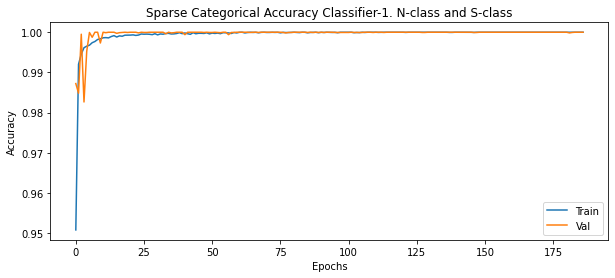

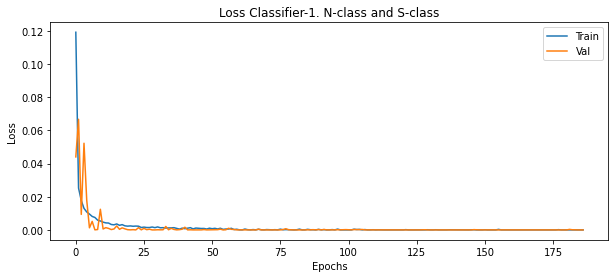

In [ ]:
plot_history(history,'Classifier-1. N-class and S-class')

In [ ]:
model_1.load_weights('best_model_1.h5')
y_pred = model_1.predict([X_test1, features_test1])
y_pred = np.argmax(y_pred, axis=1)

1432/1432 [==============================] - 6s 4ms/step


In [ ]:
np.unique(y_train1, return_counts=True), features_train1.shape

((array([0, 1]), array([45766, 45766])), (91532, 8))

In [ ]:
print('Classifier-1 : balance')
print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred, digits=4))

Classifier-1 : balance
[[43275   795]
 [ 1522   232]]
              precision    recall  f1-score   support

           0     0.9660    0.9820    0.9739     44070
           1     0.2259    0.1323    0.1668      1754

    accuracy                         0.9494     45824
   macro avg     0.5960    0.5571    0.5704     45824
weighted avg     0.9377    0.9494    0.9430     45824



Encoder Network perform worse, we will use MLP Network. This time, we use features-RR only

In [ ]:
features_train1, y_train1 = smt.fit_resample(features_train1, y_train1)
num_class = len(np.unique(y_train1))
model_1_1 = make_MLP(input_shape=features_train1.shape[1:], num_class=num_class)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model_1_1.h5", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=50, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, verbose=1),
]

model_1_1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

In [ ]:
features_train1.shape[1:], num_class, features_train1.shape, y_train1.shape, np.unique(y_train1, return_counts=True)
# features_train1[0]

((8,), 2, (91532, 8), (91532,), (array([0, 1]), array([45766, 45766])))

In [ ]:
batch_size = 128
epochs = 1000
history = model_1_1.fit(
    features_train1,
    y_train1,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

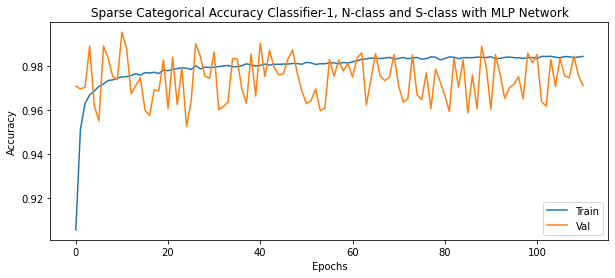

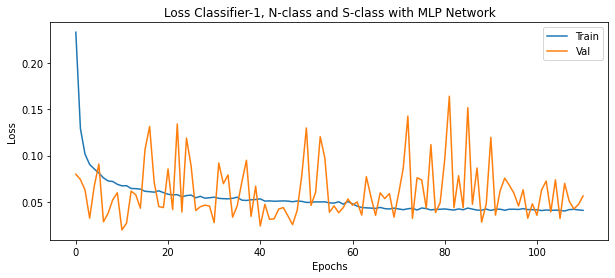

In [ ]:
plot_history(history,'Classifier-1, N-class and S-class with MLP Network')

In [ ]:
# !cp drive/MyDrive/Kuliah/thesis/models/best_model_1_1.h5 ./ 
model_1_1.load_weights('best_model_1_1.h5')
y_pred = model_1_1.predict(features_test1)
y_pred = np.argmax(y_pred, axis=1)

1432/1432 [==============================] - 2s 2ms/step


In [ ]:
print('Classifier-1 : Balance (MLP Network)')
print(np.unique(y_train1, return_counts=True))
print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred, digits=4))

Classifier-1 : Balance (MLP Network)
(array([0, 1]), array([45766, 45766]))
[[38413  5657]
 [  261  1493]]
              precision    recall  f1-score   support

           0     0.9933    0.8716    0.9285     44070
           1     0.2088    0.8512    0.3354      1754

    accuracy                         0.8709     45824
   macro avg     0.6010    0.8614    0.6319     45824
weighted avg     0.9632    0.8709    0.9058     45824



Classifier-1 : use xgboost

In [ ]:
clf = xgb.XGBClassifier(tree_method='gpu_hist')
clf.fit(features_train1, y_train1)
y_pred = clf.predict(features_test1)
print('Classifier-1 : Balance (XGBoost)')
print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred, digits=4))

Classifier-1 : Balance (XGBoost)
[[41589  2481]
 [ 1345   409]]
              precision    recall  f1-score   support

           0     0.9687    0.9437    0.9560     44070
           1     0.1415    0.2332    0.1761      1754

    accuracy                         0.9165     45824
   macro avg     0.5551    0.5884    0.5661     45824
weighted avg     0.9370    0.9165    0.9262     45824



Classifier-2 : to classify V and F class

Original Encoder - then restore with various tuning, dense, batch, activation

In [ ]:
# xx = X_train2.reshape(X_train2.shape[0], X_train2.shape[1])
print(X_train2.shape)
print(features_train2.shape)
xx = X_train2
my_x = np.concatenate([xx, features_train2], axis=1)
my_x, y_train2 = smt.fit_resample(my_x, y_train2)

# my_x.shape
X_train2 = my_x[:, :-8]
features_train2 = my_x[:, -8:]

(4196, 187)
(4196, 8)


In [ ]:

X_train = X_train2.reshape(X_train2.shape[0], X_train2.shape[1], 1)

model_2 = make_Encoder(X_train.shape[1:], features_size, num_class)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model_2_1.h5", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=25, min_lr=0.0001
    ),
    # tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model_2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

y_train2 = lbl.fit_transform(y_train2)
batch_size = 64
epochs = 200
history = model_2.fit(
    [X_train, features_train2],
    y_train2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=0,
)

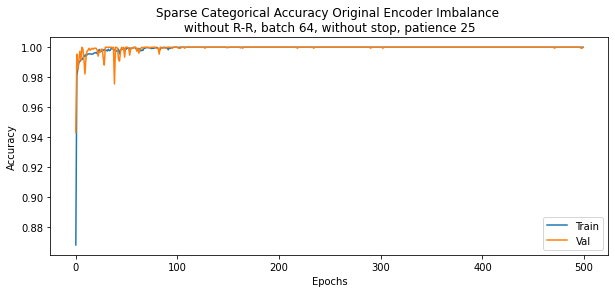

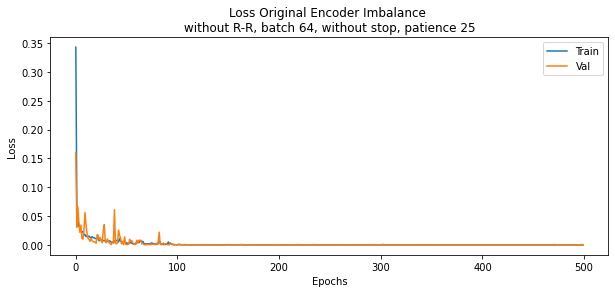

In [ ]:
plot_history(history,'Original Encoder Imbalance \n without R-R, batch 64, without stop, patience 25 ')

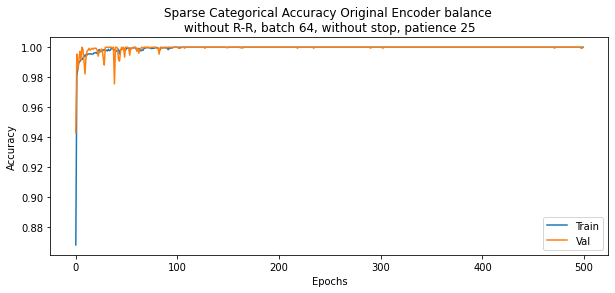

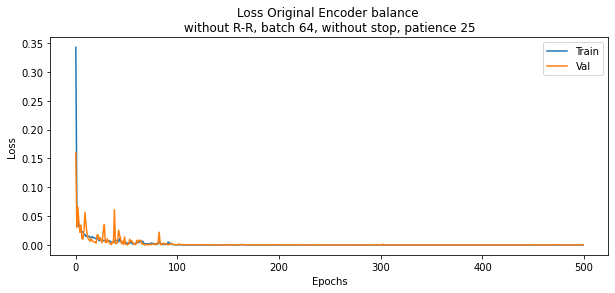

In [ ]:
plot_history(history,'Original Encoder balance \n without R-R, batch 64, without stop, patience 25 ')

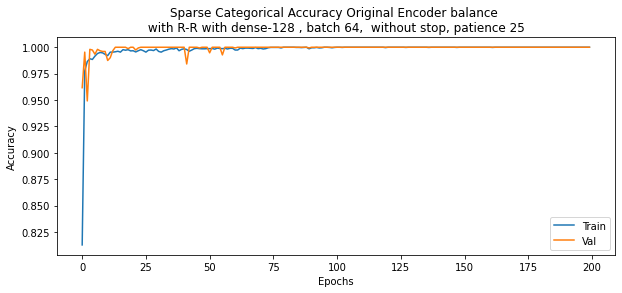

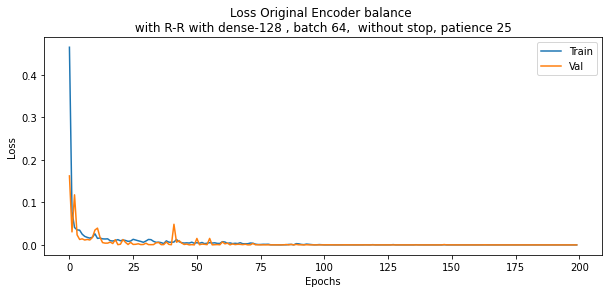

In [ ]:
plot_history(history,'Original Encoder balance \n with R-R with dense-128 , batch 64,  without stop, patience 25 ')

In [ ]:
model_2.load_weights('best_model_2_1.h5')
X_test = X_test2.reshape(X_test2.shape[0], X_test2.shape[1], 1)
y_pred = model_2.predict([X_test, features_test2])
y_pred = np.argmax(y_pred, axis=1)

y_test2 = lbl.fit_transform(y_test2)
print('Classifier-2 : balance without dense-256')
print(np.unique(y_train2, return_counts=True))
print(confusion_matrix(y_test2, y_pred))
print(classification_report(y_test2, y_pred, digits=4))


113/113 [==============================] - 1s 6ms/step
Classifier-2 : balance without dense-256
(array([0, 1]), array([3783, 3783]))
[[3100  119]
 [ 125  263]]
              precision    recall  f1-score   support

           0     0.9612    0.9630    0.9621      3219
           1     0.6885    0.6778    0.6831       388

    accuracy                         0.9324      3607
   macro avg     0.8249    0.8204    0.8226      3607
weighted avg     0.9319    0.9324    0.9321      3607



Modified Encoder

In [ ]:
# model_2.load_weights('best_model_2.h5')
X_test = X_test2.reshape(X_test2.shape[0], X_test2.shape[1], 1)
y_pred = model_2.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_test2 = lbl.fit_transform(y_test2)
print('Classifier-2 : Imbalance')
print(confusion_matrix(y_test2, y_pred))
print(classification_report(y_test2, y_pred, digits=4))


113/113 [==============================] - 1s 7ms/step
Classifier-2 : Imbalance
[[3196   23]
 [ 199  189]]
              precision    recall  f1-score   support

           0     0.9414    0.9929    0.9664      3219
           1     0.8915    0.4871    0.6300       388

    accuracy                         0.9385      3607
   macro avg     0.9164    0.7400    0.7982      3607
weighted avg     0.9360    0.9385    0.9302      3607



In [ ]:
model_2.load_weights('best_model_2_ori.h5')
X_test = X_test2.reshape(X_test2.shape[0], X_test2.shape[1], 1)
y_pred = model_2.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_test2 = lbl.fit_transform(y_test2)
print('Classifier-2 : balance')
print(confusion_matrix(y_test2, y_pred))
print(classification_report(y_test2, y_pred, digits=4))


113/113 [==============================] - 1s 7ms/step
Classifier-2 : balance
[[3139   80]
 [ 126  262]]
              precision    recall  f1-score   support

           0     0.9614    0.9751    0.9682      3219
           1     0.7661    0.6753    0.7178       388

    accuracy                         0.9429      3607
   macro avg     0.8637    0.8252    0.8430      3607
weighted avg     0.9404    0.9429    0.9413      3607



In [ ]:
# xx = X_train2.reshape(X_train2.shape[0], X_train2.shape[1])
print(X_train2.shape)
print(features_train2.shape)
xx = X_train2
my_x = np.concatenate([xx, features_train2], axis=1)
my_x, y_train2 = smt.fit_resample(my_x, y_train2)


(4196, 187)
(4196, 8)


In [ ]:
# my_x.shape
X_train2 = my_x[:, :-8]
features_train2 = my_x[:, -8:]

In [ ]:
np.unique(y_train2, return_counts=True)

(array([2, 3]), array([3783, 3783]))

In [ ]:
num_class = len(np.unique(y_train2))
features_size = features_train2.shape[1]
X_train = X_train2.reshape(X_train2.shape[0], X_train2.shape[1], 1)

model_2 = make_Modif_Encoder(X_train.shape[1:], features_size, num_class)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model_2.h5", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=25, min_lr=0.0001
    ),
    # tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model_2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])


In [ ]:
X_train.shape, features_train2.shape

((50904, 187), (7566, 8))

In [ ]:
y_train2 = lbl.fit_transform(y_train2)
batch_size = 64
epochs = 500
history = model_2.fit(
    [X_train, features_train2],
    y_train2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=0,
)

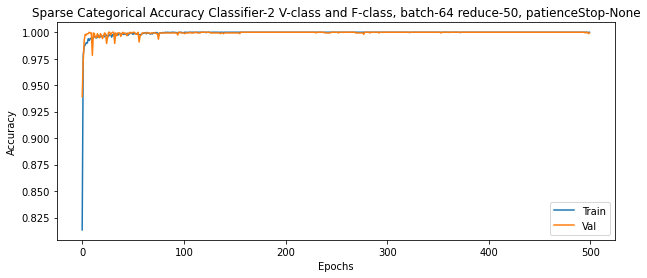

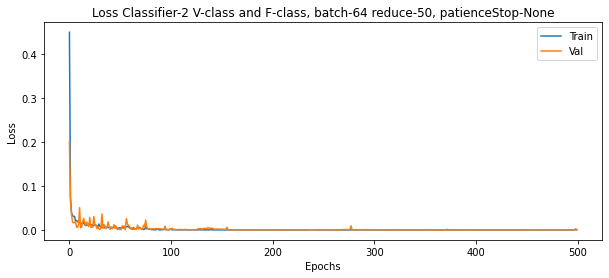

In [ ]:
plot_history(history,'Classifier-2 V-class and F-class, batch-64 reduce-50, patienceStop-None')

In [ ]:
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()

y_test2 = lbl.fit_transform(y_test2)

In [ ]:
# model_2 = make_Modif_Encoder(input_shape=X_train2.shape[1:], features_size=8, num_class=2)
X_train2 = X_train2.reshape(X_train2.shape[0], X_train2.shape[1], 1)
model_2 = make_Modif_Encoder(input_shape=X_train2.shape[1:], features_size=8, num_class=2)
model_2.load_weights('best_model_2.h5')
y_pred = model_2.predict([X_test2, features_test2])
y_pred = np.argmax(y_pred, axis=1)

113/113 [==============================] - 1s 6ms/step


In [ ]:
y_test2 = lbl.fit_transform(y_test2)
print('Classifier-2 : Imbalance')
print(confusion_matrix(y_test2, y_pred))
print(classification_report(y_test2, y_pred, digits=4))
print(np.unique(y_test2, return_counts=True))

Classifier-2 : Imbalance
[[3097  122]
 [ 120  268]]
              precision    recall  f1-score   support

           0     0.9627    0.9621    0.9624      3219
           1     0.6872    0.6907    0.6889       388

    accuracy                         0.9329      3607
   macro avg     0.8249    0.8264    0.8257      3607
weighted avg     0.9331    0.9329    0.9330      3607

(array([0, 1]), array([3219,  388]))


In [ ]:
#patience 50, reduce 50, batch 64 max epochs 500 
# [[2569  650]
#  [  12  376]]
#               precision    recall  f1-score   support

#            0     0.9954    0.7981    0.8859      3219
#            1     0.3665    0.9691    0.5318       388

#     accuracy                         0.8165      3607
#    macro avg     0.6809    0.8836    0.7088      3607
# weighted avg     0.9277    0.8165    0.8478      3607
#patience 100, reduce 50, batch 64 13nov 16.15
# [[3125   94]
#  [ 126  262]]
#               precision    recall  f1-score   support

#            0     0.9612    0.9708    0.9660      3219
#            1     0.7360    0.6753    0.7043       388

#     accuracy                         0.9390      3607
#    macro avg     0.8486    0.8230    0.8351      3607
# weighted avg     0.9370    0.9390    0.9378      3607

In [ ]:
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
y_test2 = lbl.fit_transform(y_test2)
print('Classifier-2 : From saved best-model')
print(confusion_matrix(y_test2, y_pred))
print(classification_report(y_test2, y_pred, digits=4))

Classifier-2 : From saved best-model
[[2569  650]
 [  12  376]]
              precision    recall  f1-score   support

           0     0.9954    0.7981    0.8859      3219
           1     0.3665    0.9691    0.5318       388

    accuracy                         0.8165      3607
   macro avg     0.6809    0.8836    0.7088      3607
weighted avg     0.9277    0.8165    0.8478      3607



In [ ]:
#CLASSIFIER-2
#without rr-features
# [[3144   75]
#  [ 158  230]]
#               precision    recall  f1-score   support

#            0     0.9522    0.9767    0.9643      3219
#            1     0.7541    0.5928    0.6638       388

#     accuracy                         0.9354      3607
#    macro avg     0.8531    0.7847    0.8140      3607
# weighted avg     0.9308    0.9354    0.9319      3607
#with rr-features
# [[3204   15]
#  [ 255  133]]
#               precision    recall  f1-score   support

#            0     0.9263    0.9953    0.9596      3219
#            1     0.8986    0.3428    0.4963       388

#     accuracy                         0.9251      3607
#    macro avg     0.9125    0.6691    0.7279      3607
# weighted avg     0.9233    0.9251    0.9097      3607
#try balance with rr-features
# Classifier-2 : Balance
# [[2992  227]
#  [  13  375]]
#               precision    recall  f1-score   support

#            0     0.9957    0.9295    0.9614      3219
#            1     0.6229    0.9665    0.7576       388

#     accuracy                         0.9335      3607
#    macro avg     0.8093    0.9480    0.8595      3607
# weighted avg     0.9556    0.9335    0.9395      3607


In [ ]:
!cp best_model* drive/MyDrive/Kuliah/thesis/models/

## Linked-up all network into single Model Classifier

Build model from saved best weight

In [ ]:
X_train0 = X_train0.reshape(X_train0.shape[0], X_train0.shape[1], 1)
X_train2 = X_train2.reshape(X_train2.shape[0], X_train2.shape[1], 1)

model_0 = make_Modif_Encoder(input_shape=X_train0.shape[1:], features_size=8, num_class=2)
my_model_1 = make_MLP(features_train1.shape[1], num_class=2)
model_2 = make_Modif_Encoder(input_shape=X_train0.shape[1:], features_size=8, num_class=2)

model_0.load_weights('best_model_0.h5')
my_model_1.load_weights('best_model_1_1.h5')
model_2.load_weights('best_model_2.h5')

Prepare test dataset

In [ ]:
X_train = train_dataset.iloc[:, 4:191].to_numpy().astype(float)
X_test = test_dataset.iloc[:, 4:191].to_numpy().astype(float)
record = test_dataset.iloc[:, 0].to_numpy().astype(int)

y_train = train_dataset.loc[:,1].to_numpy().astype(int)
y_test =  test_dataset.loc[:,1].to_numpy().astype(int)


features_train = train_dataset.iloc[:, [2, 3, 192, 193, 194, 195, 196, 197]].to_numpy().astype(float)
features_test = test_dataset.iloc[:, [2, 3, 192, 193, 194, 195, 196, 197]].to_numpy().astype(float)

features_train = mx.fit_transform(features_train)
features_test = mx.fit_transform(features_test)

In [ ]:
predictions = []
for i, xf in tqdm(enumerate(zip(X_test, features_test, record)), total=len(X_test)):  
  
  x = xf[0].reshape(1, xf[0].shape[0], 1) #transform to 3dim
  f = xf[1].reshape(1, xf[1].shape[0])  
  y0 = model_0.predict([x, f], verbose=0) # model_0 required two inputs
  y0 = np.argmax(y0, axis=1)
  if y0 == 0:
    y1 = model_1_1.predict(f, verbose=0)
    y1 = np.argmax(y1, axis=1)
    if y1 == 0:
      predictions.append((xf[2],0))
    else:
      predictions.append((xf[2],1))
  else:
    y2 = model_2.predict([x, f], verbose=0)
    y2 = np.argmax(y2, axis=1)
    if y2 != 0:
      predictions.append((xf[2], 3))
    else:
      predictions.append((xf[2], 2))
  
print('\n Prediction all test has done !')

100%|██████████| 49431/49431 [1:14:56<00:00, 10.99it/s]


 Prediction all test has done !


In [ ]:
y_pred = np.array(predictions)
np.save('result_predict_13_1228', y_pred)
!cp result_predict* drive/MyDrive/Kuliah/thesis/models/
np.unique(y_pred, return_counts=True)

(array([  0,   1,   2,   3, 100, 103, 105, 111, 113, 117, 121, 123, 200,
        202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234]),
 array([41034,  5063,  3232,   102,  2269,  2082,  2565,  2122,  1792,
         1533,  1860,  1516,  2598,  2133,  2646,  2745,  3246,  2256,
         2146,  2425,  2479,  2051,  1569,  1573,  3075,  2750]))

In [ ]:
print('Classifier-ALL : 2-stages with new model_2')
target_names = ['class N', 'class S', 'class V',' class F']
print(confusion_matrix(y_test, y_pred[:, 1]))
print(accuracy_score(y_test, y_pred[:, 1]))
print(classification_report(y_test, y_pred[:, 1], digits=4, target_names=target_names))

Classifier-ALL : 2-stages with new model_2
[[40144  3689   191    46]
 [  464  1138   152     0]
 [   83   232  2851    53]
 [  343     4    38     3]]
0.8928809856163137
              precision    recall  f1-score   support

     class N     0.9783    0.9109    0.9434     44070
     class S     0.2248    0.6488    0.3339      1754
     class V     0.8821    0.8857    0.8839      3219
     class F     0.0294    0.0077    0.0122       388

    accuracy                         0.8929     49431
   macro avg     0.5287    0.6133    0.5434     49431
weighted avg     0.9379    0.8929    0.9106     49431



In [ ]:
np.save('y_pred_all_1', y_pred)

In [ ]:
!cp y_pred_all_1* drive/MyDrive/Kuliah/thesis/models/

In [ ]:
print('Classifier-ALL : 2-stages. 2nd try')
target_names = ['class N', 'class S', 'class V',' class F']
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4, target_names=target_names))

Classifier-ALL : 2-stages. 2nd try
[[39757  3693   189   431]
 [  533  1213     8     0]
 [   22   267  2454   476]
 [  278     6     7    97]]
0.8804394003762821
              precision    recall  f1-score   support

     class N     0.9795    0.9021    0.9392     44070
     class S     0.2342    0.6916    0.3499      1754
     class V     0.9233    0.7623    0.8351      3219
     class F     0.0966    0.2500    0.1394       388

    accuracy                         0.8804     49431
   macro avg     0.5584    0.6515    0.5659     49431
weighted avg     0.9424    0.8804    0.9052     49431



In [ ]:
 !cp drive/MyDrive/Kuliah/thesis/models/best_model* ./

In [ ]:
 !cp drive/MyDrive/Kuliah/thesis/models/result_predict* ./
 !cp drive/MyDrive/Kuliah/thesis/models/y_pred* ./

In [ ]:
y_pred = np.load('result_predict.npy')

In [ ]:
df = pd.DataFrame(y_pred, columns=['record','beat-type'])

In [ ]:
beats = pd.pivot_table(df, values='beat-type', index=['record'], columns=['beat-type'], aggfunc=np.count_nonzero)

In [ ]:
beats.to_excel('beats_result.xlsx')

In [ ]:
beats_test = pd.pivot_table(test_dataset[[0, 1]], values=[1], index=[0], columns=[1], aggfunc=np.count_nonzero)

In [ ]:
beats_test.to_excel('beats_test.xlsx')

In [ ]:
my_pred = y_pred[:, 1]

In [ ]:
confusion_matrix(y_test, my_pred)

array([[39757,  3693,   189,   431],
       [  533,  1213,     8,     0],
       [   22,   267,  2454,   476],
       [  278,     6,     7,    97]])

In [ ]:
np.save('y_test', y_test)

New algorithm to evaluate the model

In [ ]:
X_train = train_dataset.iloc[:, 4:191].to_numpy().astype(float)
X_test = test_dataset.iloc[:, 4:191].to_numpy().astype(float)

y_test =  test_dataset.loc[:,1].to_numpy().astype (int)

features_test = test_dataset.iloc[:, [2, 3, 192, 193, 194, 195, 196, 197]].to_numpy().astype(float)

features_test = mx.fit_transform(features_test)

X_train = reshape(X_train)

In [ ]:
model_0 = make_Modif_Encoder(X_train.shape[1:], 8, 2)
model_1 = make_MLP(features_train1.shape[1:], 2)
model_2 = make_Modif_Encoder(X_train.shape[1:], 8, 2)


model_0.load_weights('best_model_0.h5')
model_1.load_weights('best_model_1_1.h5')
model_2.load_weights('best_model_2.h5')


In [ ]:

X_test = reshape(X_test)

y0 = model_0.predict([X_test, features_test], verbose=1)
y0 = np.argmax(y0, axis=1)
idx_y1 = np.where(y0==0)
idx_y2 = np.where(y0==1)
test1 = X_test[idx_y1, :]
test2 = X_test[idx_y2, :]
feat1 = features_test[idx_y1]
feat2 = features_test[idx_y2]
test1.shape, test2.shape, feat1.shape, feat2.shape, X_test.shape

1545/1545 [==============================] - 7s 5ms/step


((1, 46097, 187, 1), (1, 3334, 187, 1), (46097, 8), (3334, 8), (49431, 187, 1))

In [ ]:
print(feat1.shape)
y1_pred = model_1.predict(feat1, verbose=1)
y1_pred = np.argmax(y1_pred, axis=1)

test2 = reshape(test2[0])
y2_pred = model_2.predict([test2, feat2], verbose=1)
y2_pred = np.argmax(y2_pred, axis=1)

new_y2 = np.where(y2_pred==0, 2, 3)

(46097, 8)
105/105 [==============================] - 1s 7ms/step


In [ ]:
y = np.zeros((len(y_test)), dtype=int)
for i, idx in enumerate(idx_y1[0]):
    y[idx] = y1_pred[i]
    
for i, idx in enumerate(idx_y2[0]):
    y[idx] = new_y2[i]
np.unique(y, return_counts=True)

(array([0, 1, 2, 3]), array([41034,  5063,  2720,   614]))

In [ ]:
print(accuracy_score(y_test, y))
print(confusion_matrix(y_test, y))
print(classification_report(y_test, y))

0.8858610993101494
[[40144  3689   109   128]
 [  464  1138   129    23]
 [   83   232  2474   430]
 [  343     4     8    33]]
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     44070
           1       0.22      0.65      0.33      1754
           2       0.91      0.77      0.83      3219
           3       0.05      0.09      0.07       388

    accuracy                           0.89     49431
   macro avg       0.54      0.60      0.54     49431
weighted avg       0.94      0.89      0.91     49431



In [ ]:
!mkdir drive/MyDrive/Kuliah/thesis/models/13nov2130

In [ ]:
!cp best_model* drive/MyDrive/Kuliah/thesis/models/13nov2130

## Find best params for model-2

In [ ]:
print(X_train2.shape)
print(features_train2.shape)
xx = X_train2
my_x = np.concatenate([xx, features_train2], axis=1)
my_x, y_train2 = smt.fit_resample(my_x, y_train2)

# my_x.shape
X_train2 = my_x[:, :-8]
features_train2 = my_x[:, -8:]


np.unique(y_train2, return_counts=True)

num_class = len(np.unique(y_train2))
features_size = features_train2.shape[1]
X_train = X_train2.reshape(X_train2.shape[0], X_train2.shape[1], 1)

(4196, 187)
(4196, 8)


In [ ]:
x_batch = [32, 64, 128]
x_reduce = [10, 25, 50]
# x_batch = [64]
# x_reduce = [10]


y_train2 = lbl.fit_transform(y_train2)
y_test2 = lbl.fit_transform(y_test2)

for b in x_batch:
  for r in x_reduce:    

    model_2 = make_Modif_Encoder(X_train.shape[1:], features_size, num_class)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            "best_model_2.h5", save_best_only=True, monitor="val_loss"
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=r, min_lr=0.0001
        ),
        # tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
    ]

    model_2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

    
    batch_size = b
    epochs = 500
    history = model_2.fit(
        [X_train, features_train2],
        y_train2,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_split=0.2,
        verbose=0,
    )
    model_2.load_weights('best_model_2.h5')
    X_test = X_test2.reshape(X_test2.shape[0], X_test2.shape[1], 1)
    y_pred = model_2.predict([X_test, features_test2])
    y_pred = np.argmax(y_pred, axis=1)

    
    print(" Performance for params batch = ", b," reduce = ",r)
    print(confusion_matrix(y_test2, y_pred))
    print(classification_report(y_test2, y_pred, digits=4))
    print(accuracy_score(y_test2, y_pred))
    print('===================================')
    print('\n')

113/113 [==============================] - 1s 5ms/step
 Performance for params batch =  32  reduce =  10
[[3133   86]
 [ 152  236]]
              precision    recall  f1-score   support

           0     0.9537    0.9733    0.9634      3219
           1     0.7329    0.6082    0.6648       388

    accuracy                         0.9340      3607
   macro avg     0.8433    0.7908    0.8141      3607
weighted avg     0.9300    0.9340    0.9313      3607

0.9340171887995564


113/113 [==============================] - 1s 6ms/step
 Performance for params batch =  32  reduce =  25
[[3132   87]
 [ 151  237]]
              precision    recall  f1-score   support

           0     0.9540    0.9730    0.9634      3219
           1     0.7315    0.6108    0.6657       388

    accuracy                         0.9340      3607
   macro avg     0.8427    0.7919    0.8146      3607
weighted avg     0.9301    0.9340    0.9314      3607

0.9340171887995564


113/113 [==============================]

## Parameter search for model-1

In [ ]:
np.unique(y_train1, return_counts=True)
# rus = RandomUnderSampler(sampling_strategy={0:20000})
# features_train1, y_train1 = rus.fit_resample(features_train1, y_train1)
features_train1, y_train1 = smt.fit_resample(features_train1, y_train1)
np.unique(y_train1, return_counts=True)

(array([0, 1]), array([45766, 45766]))

(array([0, 1]), array([45786, 45786]))
1436/1436 [==============================] - 2s 1ms/step
 Performance for params batch =  64  reduce =  5
(array([0, 1]), array([45786, 45786]))
[[26879 17268]
 [  967   835]]
              precision    recall  f1-score   support

           0     0.9653    0.6089    0.7467     44147
           1     0.0461    0.4634    0.0839      1802

    accuracy                         0.6031     45949
   macro avg     0.5057    0.5361    0.4153     45949
weighted avg     0.9292    0.6031    0.7207     45949

0.6031469672898213




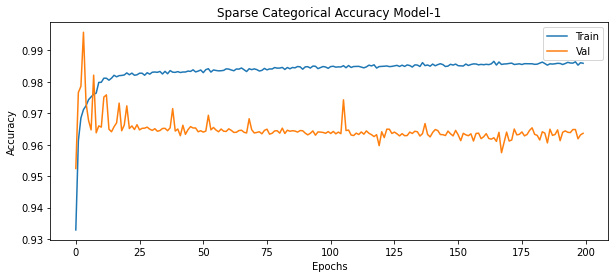

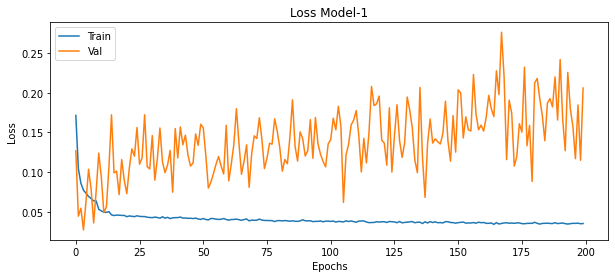

1436/1436 [==============================] - 2s 2ms/step
 Performance for params batch =  64  reduce =  10
(array([0, 1]), array([45786, 45786]))
[[28683 15464]
 [ 1115   687]]
              precision    recall  f1-score   support

           0     0.9626    0.6497    0.7758     44147
           1     0.0425    0.3812    0.0765      1802

    accuracy                         0.6392     45949
   macro avg     0.5026    0.5155    0.4262     45949
weighted avg     0.9265    0.6392    0.7484     45949

0.6391869246338332




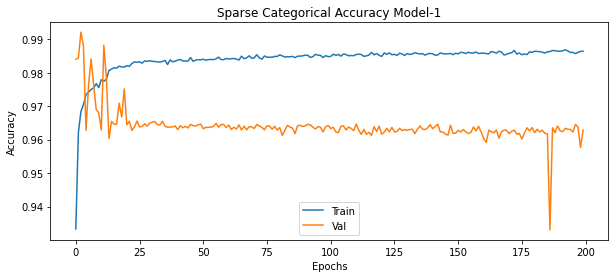

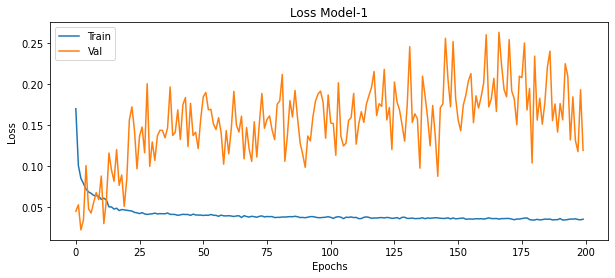

1436/1436 [==============================] - 3s 2ms/step
 Performance for params batch =  128  reduce =  5
(array([0, 1]), array([45786, 45786]))
[[32201 11946]
 [ 1123   679]]
              precision    recall  f1-score   support

           0     0.9663    0.7294    0.8313     44147
           1     0.0538    0.3768    0.0941      1802

    accuracy                         0.7156     45949
   macro avg     0.5100    0.5531    0.4627     45949
weighted avg     0.9305    0.7156    0.8024     45949

0.715575964656467




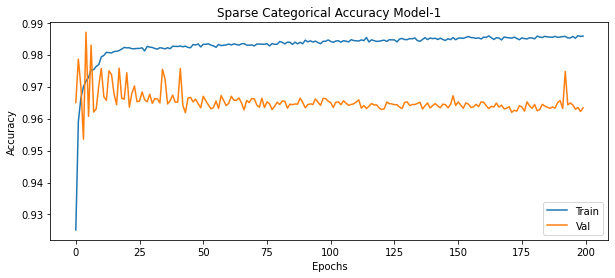

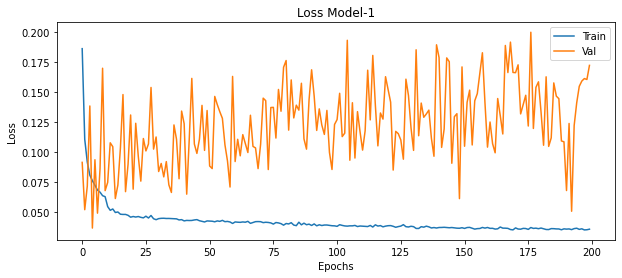

1436/1436 [==============================] - 2s 2ms/step
 Performance for params batch =  128  reduce =  10
(array([0, 1]), array([45786, 45786]))
[[32122 12025]
 [ 1129   673]]
              precision    recall  f1-score   support

           0     0.9660    0.7276    0.8300     44147
           1     0.0530    0.3735    0.0928      1802

    accuracy                         0.7137     45949
   macro avg     0.5095    0.5505    0.4614     45949
weighted avg     0.9302    0.7137    0.8011     45949

0.7137260876188818




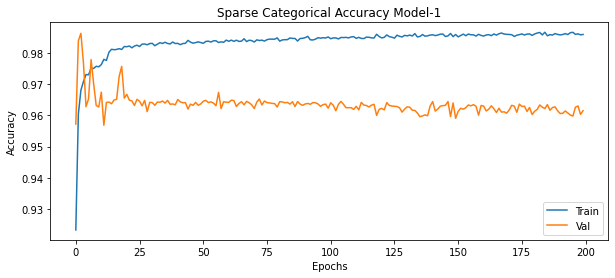

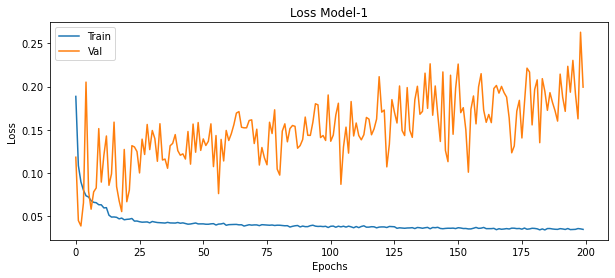

In [ ]:
print(np.unique(y_train1, return_counts=True))
# x_batch = [32, 64, 128]
# x_reduce = [5, 10, 25, 50]

x_batch = [64, 128]
x_reduce = [5, 10]

# rus = RandomUnderSampler(sampling_strategy={0:20000})
# features_train1, y_train1 = rus.fit_resample(features_train1, y_train1)
# features_train1, y_train1 = smt.fit_resample(features_train1, y_train1)



for b in x_batch:
    for r in x_reduce:
        mdl_name = 'best_model_1_'+str(b)+'_'+str(r)+'.h5'   
        model_1 = make_MLP(features_train1.shape[1:], len(np.unique(y_train1)))
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                mdl_name, save_best_only=True, monitor="val_loss"
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss", factor=0.25, patience=r, min_lr=0.0001
            ),
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, verbose=1),
        ]

        model_1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
        batch_size = b
        epochs = 200
        history = model_1.fit(
            features_train1,
            y_train1,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            validation_split=0.2,
            # class_weight=cw,
            verbose=0,
        )
        
        model_1.load_weights(mdl_name)
        y_pred = model_1.predict(features_test1, verbose=1)
        y_pred = np.argmax(y_pred, axis=1)

        print(" Performance for params batch = ", b," reduce = ",r)
        print(np.unique(y_train1, return_counts=True))
        print(confusion_matrix(y_test1, y_pred))
        print(classification_report(y_test1, y_pred, digits=4))
        print(accuracy_score(y_test1, y_pred))
        print('===================================')
        print('\n')
        plot_history(history,'Model-1')

Hyperparameter search for model-0

In [ ]:
print(X_train0.shape)
print(features_train0.shape)
xx = X_train0
my_x = np.concatenate([xx, features_train0], axis=1)
my_x, y_train0 = smt.fit_resample(my_x, y_train0)
my_x.shape, y_train0.shape

# my_x.shape
X_train0 = my_x[:, :-8]
features_train0 = my_x[:, -8:]
X_train0.shape, features_train0.shape




(50904, 187)
(50904, 8)


((93416, 187), (93416, 8))

In [ ]:
from time import time
t0 = time()
for i in range(1000):
  a = i* 100
  
print(time()-t0)

0.0002663135528564453


Epoch 148: early stopping
1545/1545 [==============================] - 8s 5ms/step
Time elapsed for one-cycle  5 64 4317.1832139492035
 Performance for params batch =  64  reduce =  5
(array([0, 1]), array([46708, 46708]))
Classifier-0 : Balance
[[41431  4393]
 [  394  3213]]
              precision    recall  f1-score   support

           0     0.9906    0.9041    0.9454     45824
           1     0.4224    0.8908    0.5731      3607

    accuracy                         0.9032     49431
   macro avg     0.7065    0.8975    0.7592     49431
weighted avg     0.9491    0.9032    0.9182     49431

0.9031579373267787




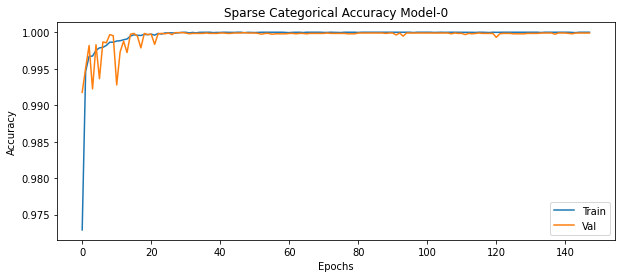

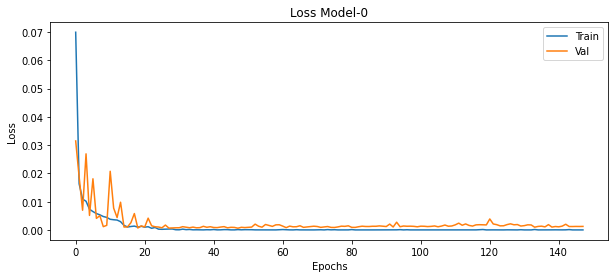

Epoch 117: early stopping
1545/1545 [==============================] - 8s 5ms/step
Time elapsed for one-cycle  10 64 3394.910879135132
 Performance for params batch =  64  reduce =  10
(array([0, 1]), array([46708, 46708]))
Classifier-0 : Balance
[[43936  1888]
 [  394  3213]]
              precision    recall  f1-score   support

           0     0.9911    0.9588    0.9747     45824
           1     0.6299    0.8908    0.7379      3607

    accuracy                         0.9538     49431
   macro avg     0.8105    0.9248    0.8563     49431
weighted avg     0.9648    0.9538    0.9574     49431

0.953834638182517




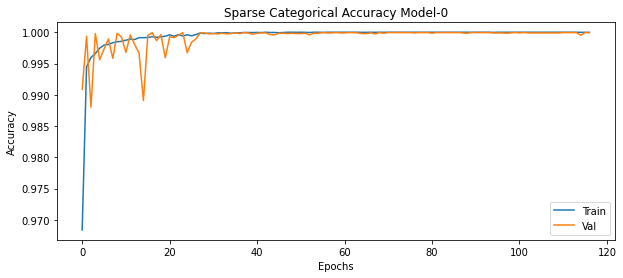

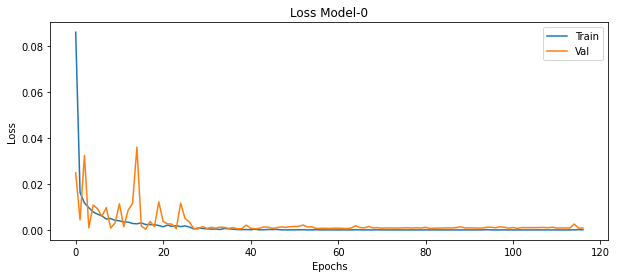

Epoch 125: early stopping
1545/1545 [==============================] - 8s 5ms/step
Time elapsed for one-cycle  5 128 3114.1186780929565
 Performance for params batch =  128  reduce =  5
(array([0, 1]), array([46708, 46708]))
Classifier-0 : Balance
[[42877  2947]
 [  357  3250]]
              precision    recall  f1-score   support

           0     0.9917    0.9357    0.9629     45824
           1     0.5244    0.9010    0.6630      3607

    accuracy                         0.9332     49431
   macro avg     0.7581    0.9184    0.8129     49431
weighted avg     0.9576    0.9332    0.9410     49431

0.9331593534421719




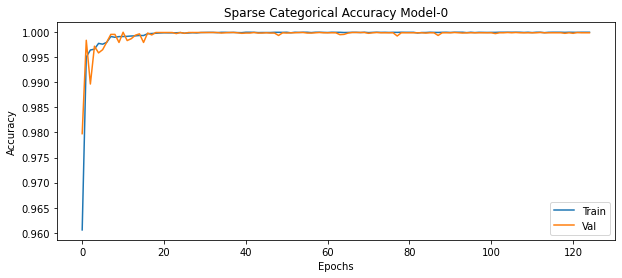

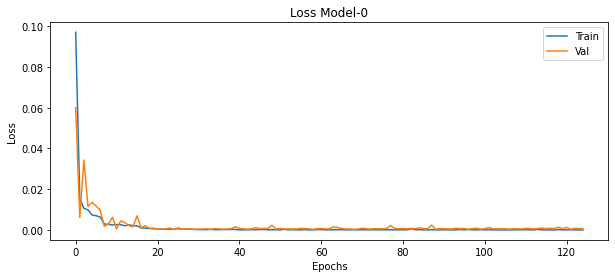

1545/1545 [==============================] - 8s 5ms/step
Time elapsed for one-cycle  10 128 4979.745783567429
 Performance for params batch =  128  reduce =  10
(array([0, 1]), array([46708, 46708]))
Classifier-0 : Balance
[[44337  1487]
 [  403  3204]]
              precision    recall  f1-score   support

           0     0.9910    0.9675    0.9791     45824
           1     0.6830    0.8883    0.7722      3607

    accuracy                         0.9618     49431
   macro avg     0.8370    0.9279    0.8757     49431
weighted avg     0.9685    0.9618    0.9640     49431

0.9617648843842933




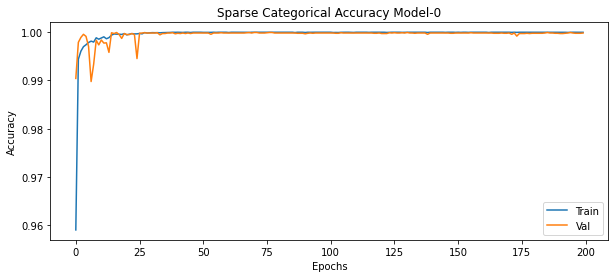

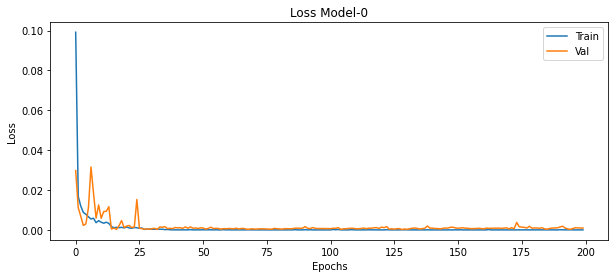

In [ ]:
from time import time

num_class = len(np.unique(y_train0))
features_size = features_train0.shape[1]
X_train = X_train0.reshape(X_train0.shape[0], X_train0.shape[1], 1)

# x_batch = [32, 64, 128]
# x_reduce = [10, 25, 50]
x_batch = [64, 128]
x_reduce = [5, 10]

for b in x_batch:
    for r in x_reduce:
      t0 = time()
      model_0 = make_Modif_Encoder(X_train.shape[1:], features_size, num_class)

      callbacks = [
          tf.keras.callbacks.ModelCheckpoint(
              "best_model_0.h5", save_best_only=True, monitor="val_loss"
          ),
          tf.keras.callbacks.ReduceLROnPlateau(
              monitor="val_loss", factor=0.5, patience=r, min_lr=0.0001
          ),
          tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, verbose=1),
      ]

      model_0.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

      batch_size = b
      epochs = 200
      history = model_0.fit(
          [X_train, features_train0],
          y_train0,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks,
          validation_split=0.2,    
          verbose=0,
      )

      X_test = X_test0.reshape(X_test0.shape[0], X_test0.shape[1], 1)

      model_0.load_weights('best_model_0.h5')
      y_pred = model_0.predict([X_test, features_test0])
      y_pred = np.argmax(y_pred, axis=1)
      print('Time elapsed for one-cycle ',r, b, time()-t0)
      print(" Performance for params batch = ", b," reduce = ",r)
      print(np.unique(y_train0, return_counts=True))
      print('Classifier-0 : Balance')
      print(confusion_matrix(y_test0, y_pred))
      print(classification_report(y_test0, y_pred, digits=4))
      print(accuracy_score(y_test0, y_pred))
      print('===================================')
      print('\n')
      plot_history(history,'Model-0')

In [ ]:
#with 4 epochs, batch 64, reduce 25
# [[42612  3212]
#  [  445  3162]]
#               precision    recall  f1-score   support

#            0     0.9897    0.9299    0.9589     45824
#            1     0.4961    0.8766    0.6336      3607

#     accuracy                         0.9260     49431
#    macro avg     0.7429    0.9033    0.7962     49431
# weighted avg     0.9536    0.9260    0.9351     49431

# FINAL MODEL

Baseline Encoder model

In [ ]:
#Train
X_train = train_dataset.iloc[:, 4:191].to_numpy().astype(float)
rec_no_train = train_dataset.iloc[:, 1].to_numpy().astype(int)

y_train =  train_dataset.loc[:,1].to_numpy().astype (int)

features_train = train_dataset.iloc[:, [2, 3, 192, 193, 194, 195, 196, 197]].to_numpy().astype(float)

features_train = mx.fit_transform(features_train)

# X_train = reshape(X_train)



#Test 
X_test = test_dataset.iloc[:, 4:191].to_numpy().astype(float)
rec_no = test_dataset.iloc[:, 1].to_numpy().astype(int)

y_test =  test_dataset.loc[:,1].to_numpy().astype (int)

features_test = test_dataset.iloc[:, [2, 3, 192, 193, 194, 195, 196, 197]].to_numpy().astype(float)

features_test = mx.fit_transform(features_test)

X_test = reshape(X_test)


In [ ]:
print(X_train.shape)
print(features_train.shape)
xx = X_train
my_x = np.concatenate([xx, features_train], axis=1)
my_x, y_train = smt.fit_resample(my_x, y_train)

# my_x.shape
X_train = my_x[:, :-8]
features_train = my_x[:, -8:]
X_train.shape, features_train.shape, np.unique(y_train, return_counts=True)

(50904, 187)
(50904, 8)


((183064, 187),
 (183064, 8),
 (array([0, 1, 2, 3]), array([45766, 45766, 45766, 45766])))

In [ ]:
num_class = len(np.unique(y_train))
features_size = features_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


Epoch 1/500
1145/1145 [==============================] - 61s 44ms/step - loss: 0.1899 - sparse_categorical_accuracy: 0.9315 - val_loss: 0.1770 - val_sparse_categorical_accuracy: 0.9541 - lr: 0.0010
Epoch 2/500
1145/1145 [==============================] - 52s 45ms/step - loss: 0.0280 - sparse_categorical_accuracy: 0.9913 - val_loss: 0.1225 - val_sparse_categorical_accuracy: 0.9592 - lr: 0.0010
Epoch 3/500
1145/1145 [==============================] - 53s 47ms/step - loss: 0.0186 - sparse_categorical_accuracy: 0.9942 - val_loss: 0.1172 - val_sparse_categorical_accuracy: 0.9720 - lr: 0.0010
Epoch 4/500
1145/1145 [==============================] - 53s 47ms/step - loss: 0.0143 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.0884 - val_sparse_categorical_accuracy: 0.9667 - lr: 0.0010
Epoch 5/500
1145/1145 [==============================] - 53s 46ms/step - loss: 0.0131 - sparse_categorical_accuracy: 0.9961 - val_loss: 0.0260 - val_sparse_categorical_accuracy: 0.9954 - lr: 0.0010
Epoch 6/50

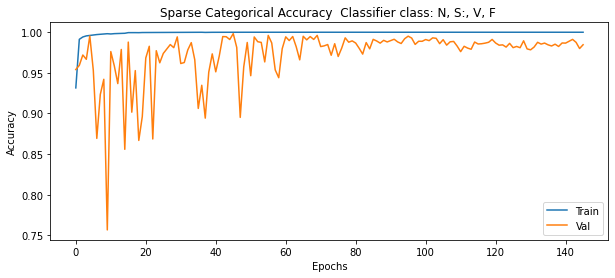

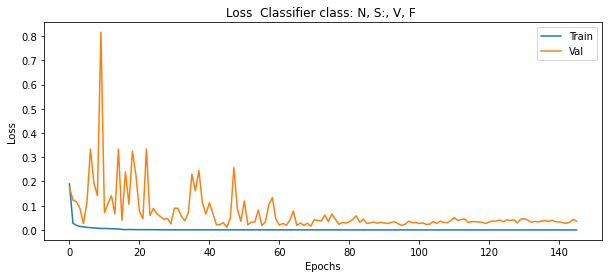

1545/1545 [==============================] - 8s 5ms/step
Classifier-ALL : Balance
[[44045     8     0    17]
 [ 1681    66     7     0]
 [ 1087     4  2119     9]
 [  387     0     1     0]]
              precision    recall  f1-score   support

           0     0.9332    0.9994    0.9652     44070
           1     0.8462    0.0376    0.0721      1754
           2     0.9962    0.6583    0.7927      3219
           3     0.0000    0.0000    0.0000       388

    accuracy                         0.9352     49431
   macro avg     0.6939    0.4238    0.4575     49431
weighted avg     0.9269    0.9352    0.9147     49431

0.9352430660921284


In [ ]:
model_All = make_Modif_Encoder(X_train.shape[1:], features_size, num_class)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model_ALL_2011.h5", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.00001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, verbose=1),
]

model_All.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])


batch_size = 128
epochs = 500
history = model_All.fit(
    [X_train, features_train],
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,    
    verbose=1,
)

plot_history(history,' Classifier class: N, S:, V, F ')

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model_All.load_weights('best_model_ALL_2011.h5')
y_pred = model_All.predict([X_test, features_test])
y_pred = np.argmax(y_pred, axis=1)

print('Classifier-ALL : Balance')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
print(accuracy_score(y_test, y_pred))

In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
model_json = model_All.to_json()

with open("model_ALL.json", "w") as json_file:
    json_file.write(model_json)

np.save('y_pred', y_pred)
np.save('y_test', y_test)
np.save('history', history)

print("Saved model to disk")

!cp model_ALL.json drive/MyDrive/Kuliah/thesis/outputs/20nov
!cp best_model_ALL_* drive/MyDrive/Kuliah/thesis/outputs/20nov
!cp y_* drive/MyDrive/Kuliah/thesis/outputs/20nov
!cp history* drive/MyDrive/Kuliah/thesis/outputs/20nov


Saved model to disk


Build classifier-0. Model to classify class-NS and class-VF

In [ ]:
#resample train data with majority class
print(X_train0.shape)
print(features_train0.shape)
xx = X_train0
my_x = np.concatenate([xx, features_train0], axis=1)
my_x, y_train0 = smt.fit_resample(my_x, y_train0)
print(my_x.shape, y_train0.shape)

# my_x.shape
X_train0 = my_x[:, :-8]
features_train0 = my_x[:, -8:]
print(X_train0.shape, features_train0.shape)

num_class = len(np.unique(y_train0))
features_size = features_train0.shape[1]
X_train = X_train0.reshape(X_train0.shape[0], X_train0.shape[1], 1)

model_0 = make_Modif_Encoder(X_train.shape[1:], features_size, num_class)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model_0_0501.h5", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.00001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, verbose=1),
]

model_0.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])


batch_size = 128
epochs = 500
history = model_0.fit(
    [X_train, features_train0],
    y_train0,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,    
    verbose=1,
)

plot_history(history,' Classifier-0, N-S:Class and V-F:Class')

X_test = X_test0.reshape(X_test0.shape[0], X_test0.shape[1], 1)

model_0.load_weights('best_model_0_0501.h5')
y_pred = model_0.predict([X_test, features_test0])
y_pred = np.argmax(y_pred, axis=1)

print('Classifier-0 : Balance')
print(confusion_matrix(y_test0, y_pred))
print(classification_report(y_test0, y_pred, digits=4))
print(accuracy_score(y_test0, y_pred))

In [ ]:
!cp best_model_0_0501* drive/MyDrive/Kuliah/thesis/models/15nov2200/

# [[45435   389]
#  [  662  2945]]

In [ ]:
np.save('history', history.history)
!cp history* drive/MyDrive/Kuliah/thesis/models/15nov2200/

Model-1 : Classifier class-N and class-S

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
features_train1, y_train1 = smt.fit_resample(features_train1, y_train1) 

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(25, 10),  random_state=42, activation='identity', 
                validation_fraction=0.1, solver='adam', alpha=0.0001, max_iter=400,  
                # learning_rate_init=0.1,learning_rate='adaptive', 
                verbose=0,momentum=0.03)
clf.fit(features_train1, y_train1)
y_pred = clf.predict(features_test1)

print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred, digits=4))

[[ 3538 40609]
 [    2  1800]]
              precision    recall  f1-score   support

           0     0.9994    0.0801    0.1484     44147
           1     0.0424    0.9989    0.0814      1802

    accuracy                         0.1162     45949
   macro avg     0.5209    0.5395    0.1149     45949
weighted avg     0.9619    0.1162    0.1458     45949



In [ ]:
features_test1.shape, features_train1.shape, y_train1.shape

((45949, 8), (91572, 8), (91572,))

This model, get from Modif encoder without Dense 128 !!!!

In [ ]:
import pickle
pickle.dump(clf, open('best_model1_15nov22.sav', 'wb'))

In [ ]:
!cp best_model1_* drive/MyDrive/Kuliah/thesis/models/15nov2200/

Model-2 : Classifier class-V and class-F

In [ ]:
#resample train data with majority class
print(X_train2.shape)
print(features_train2.shape)
xx = X_train2
my_x = np.concatenate([xx, features_train2], axis=1)
my_x, y_train2 = smt.fit_resample(my_x, y_train2)
print(my_x.shape, y_train2.shape)

# my_x.shape
X_train2 = my_x[:, :-8]
features_train2 = my_x[:, -8:]
print(X_train2.shape, features_train2.shape)

num_class = len(np.unique(y_train2))
features_size = features_train2.shape[1]
X_train = X_train2.reshape(X_train2.shape[0], X_train2.shape[1], 1)

y_train2 = lbl.fit_transform(y_train2)

model_2 = make_Modif_Encoder(X_train.shape[1:], features_size, num_class)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model_2.h5", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model_2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])


batch_size = 128
epochs = 200
history = model_2.fit(
    [X_train, features_train2],
    y_train2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,    
    verbose=1,
)

plot_history(history,' Classifier-2, V:Class and F:Class')

X_test = X_test2.reshape(X_test2.shape[0], X_test2.shape[1], 1)

model_2.load_weights('best_model_2.h5')
y_pred = model_2.predict([X_test2, features_test2])
y_pred = np.argmax(y_pred, axis=1)

print('Classifier-0 : Balance')
print(confusion_matrix(y_test2, y_pred))
print(classification_report(y_test2, y_pred, digits=4))
print(accuracy_score(y_test2, y_pred))

In [ ]:
!cp best_model_2* drive/MyDrive/Kuliah/thesis/models/15nov2200/best_model_2_v9288.h5

In [ ]:
get_class(y_train2)

(array([0, 1]), array([3783, 3783]))

In [ ]:
!cp
print('Classifier-2 : Balance')
print(confusion_matrix(y_test2, y_pred))
print(classification_report(y_test2, y_pred, digits=4))
print(accuracy_score(y_test2, y_pred))

Classifier-0 : Balance
[[3168   51]
 [ 386    2]]
              precision    recall  f1-score   support

           0     0.8914    0.9842    0.9355      3219
           1     0.0377    0.0052    0.0091       388

    accuracy                         0.8788      3607
   macro avg     0.4646    0.4947    0.4723      3607
weighted avg     0.7996    0.8788    0.8358      3607

0.8788466869975049


In [ ]:
X_train.shape, features_train2.shape, y_train2.shape, get_class(y_train2)

((7566, 187, 1), (7566, 8), (7566,), (array([0, 1]), array([3783, 3783])))

In [ ]:
X_test.shape, features_test2.shape, y_test2.shape, get_class(y_test2)

((3607, 187, 1), (3607, 8), (3607,), (array([0, 1]), array([3219,  388])))

# Final Evaluation

In [ ]:
!cp drive/MyDrive/Kuliah/thesis/models/18nov/model0/* ./
!cp drive/MyDrive/Kuliah/thesis/models/18nov/model1/* ./
!cp drive/MyDrive/Kuliah/thesis/models/18nov/model2/* ./

!cp drive/MyDrive/Kuliah/thesis/models/15nov2200/best_model1_15nov22.sav ./
!cp drive/MyDrive/Kuliah/thesis/models/15nov2200/best_model_2_v8994.h5 ./
!cp drive/MyDrive/Kuliah/thesis/models/15nov2200/best_model_0* ./

In [ ]:
!cp drive/MyDrive/Kuliah/thesis/models/18nov/model2/* ./

Classifier-0

In [ ]:
num_class = len(np.unique(y_train0))
features_size = features_train0.shape[1]
X_train = X_train0.reshape(X_train0.shape[0], X_train0.shape[1], 1)

model_0 = make_Modif_Encoder(X_train.shape[1:], features_size, num_class)

# model_0.load_weights('best_model_0.h5')
# model_0.load_weights('best_model_0_0501.h5')
# model_0.load_weights('best_model_0_9982.h5') #the best one
# model_0.load_weights('best_model_0_9590.h5')
model_0.load_weights('best_model_0_0.35_0.3_9888.h5')
# model_0.load_weights('best_model_0_32_10_9589.h5')

y_pred = model_0.predict([X_test0, features_test0])

y_pred = np.argmax(y_pred, axis=1)
print(confusion_matrix(y_test0, y_pred))
print(classification_report(y_test0, y_pred, digits=4))

1545/1545 [==============================] - 8s 5ms/step
[[45217   607]
 [  417  3190]]
              precision    recall  f1-score   support

           0     0.9909    0.9868    0.9888     45824
           1     0.8401    0.8844    0.8617      3607

    accuracy                         0.9793     49431
   macro avg     0.9155    0.9356    0.9252     49431
weighted avg     0.9799    0.9793    0.9795     49431



Classifier-1

In [ ]:
from sklearn.neural_network import MLPClassifier

features_train1, y_train1 = smt.fit_resample(features_train1, y_train1)
clf = MLPClassifier(hidden_layer_sizes=(25, 12),  random_state=42, activation='identity', tol=0.000001,
                validation_fraction=0.1, solver='sgd', alpha=0.0001, max_iter=400, 
                batch_size=64, early_stopping=False,shuffle=True,                    
                verbose=0,momentum=0.3, learning_rate='adaptive', learning_rate_init=0.01)
clf.fit(features_train1, y_train1)
y_pred = clf.predict(features_test1)
confusion_matrix(y_test1, y_pred)


array([[42753,  1317],
       [  138,  1616]])

In [ ]:
print(classification_report(y_test1, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     44070
           1       0.55      0.92      0.69      1754

    accuracy                           0.97     45824
   macro avg       0.77      0.95      0.84     45824
weighted avg       0.98      0.97      0.97     45824



In [ ]:
import pickle
# pickle.dump(clf, open('best_model1_15nov22.sav', 'wb'))

# clf = MLPClassifier(hidden_layer_sizes=(26,65, 25),  random_state=42, activation='identity', 
#                 validation_fraction=0.1, solver='adam', alpha=0.0001, max_iter=400, 
#                     verbose=0,momentum=0.03)
# clf.fit(features_train1, y_train1)
# model_1 = pickle.load(open('best_model1_15nov22.sav', 'rb'))
# model_1 = pickle.load(open('model_1_9595.sav', 'rb'))
model_1 = pickle.load(open('model_1_9498.sav', 'rb'))
y_pred = model_1.predict(features_test1)

print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred, digits=4))


[[41551  2519]
 [   37  1717]]
              precision    recall  f1-score   support

           0     0.9991    0.9428    0.9702     44070
           1     0.4053    0.9789    0.5733      1754

    accuracy                         0.9442     45824
   macro avg     0.7022    0.9609    0.7717     45824
weighted avg     0.9764    0.9442    0.9550     45824



Classifier-2

In [ ]:
y_test2 = lbl.fit_transform(y_test2)

In [ ]:
num_class = len(np.unique(y_train2))
features_size = features_train2.shape[1]
X_train = X_train2.reshape(X_train2.shape[0], X_train2.shape[1], 1)

y_train2 = lbl.fit_transform(y_train2)

model_2 = make_Modif_Encoder(X_train.shape[1:], features_size, num_class)

# model_2.load_weights('best_model_2_v8994.h5')
# model_2.load_weights('best_model_2_tl_8699.h5')
# model_2.load_weights('best_model_2_tl_8998.h5')
# model_2.load_weights('best_model_2_tl_bs160_9487.h5')
model_2.load_weights('best_model_2_tl_bs136_9494.h5')

y_pred = model_2.predict([X_test2, features_test2])


y_pred = np.argmax(y_pred, axis=1)
print(confusion_matrix(y_test2, y_pred))
print(classification_report(y_test2, y_pred, digits=4))


113/113 [==============================] - 1s 5ms/step
[[3033  186]
 [  23  365]]
              precision    recall  f1-score   support

           0     0.9925    0.9422    0.9667      3219
           1     0.6624    0.9407    0.7774       388

    accuracy                         0.9421      3607
   macro avg     0.8275    0.9415    0.8721      3607
weighted avg     0.9570    0.9421    0.9463      3607



TIght-up all model

In [ ]:
X_test = test_dataset.iloc[:, 4:191].to_numpy().astype(float)

rec_no = test_dataset.iloc[:, 1].to_numpy().astype(int)

y_test =  test_dataset.loc[:,1].to_numpy().astype (int)

features_test = test_dataset.iloc[:, [2, 3, 192, 193, 194, 195, 196, 197]].to_numpy().astype(float)

features_test = mx.fit_transform(features_test)


In [ ]:
X_test = reshape(X_test)

y0 = model_0.predict([X_test, features_test], verbose=1)
y0 = np.argmax(y0, axis=1)
idx_y1 = np.where(y0==0)
idx_y2 = np.where(y0==1)
test1 = X_test[idx_y1, :]
test2 = X_test[idx_y2, :]
feat1 = features_test[idx_y1]
feat2 = features_test[idx_y2]
test1.shape, test2.shape, feat1.shape, feat2.shape, X_test.shape

1545/1545 [==============================] - 7s 5ms/step


((1, 45634, 187, 1), (1, 3797, 187, 1), (45634, 8), (3797, 8), (49431, 187, 1))

In [ ]:
print(feat1.shape)
y1_pred = model_1.predict(feat1)

test2 = reshape(test2[0])
y2_pred = model_2.predict([test2, feat2], verbose=1)
y2_pred = np.argmax(y2_pred, axis=1)

new_y2 = np.where(y2_pred==0, 2, 3)

(45634, 8)
119/119 [==============================] - 1s 5ms/step


In [ ]:
y_pred = np.zeros((len(y_test)), dtype=int)
for i, idx in enumerate(idx_y1[0]):
    y_pred[idx] = y1_pred[i]
    
for i, idx in enumerate(idx_y2[0]):
    y_pred[idx] = new_y2[i]
np.unique(y_pred, return_counts=True)

(array([0, 1, 2, 3]), array([42098,  3536,  3502,   295]))

In [ ]:
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
print(accuracy_score(y_test, y_pred))

0.933867411138759
[[41721  2010   283    56]
 [   58  1428   266     2]
 [   38    97  2930   154]
 [  281     1    23    83]]
              precision    recall  f1-score   support

           0     0.9910    0.9467    0.9684     44070
           1     0.4038    0.8141    0.5399      1754
           2     0.8367    0.9102    0.8719      3219
           3     0.2814    0.2139    0.2430       388

    accuracy                         0.9339     49431
   macro avg     0.6282    0.7212    0.6558     49431
weighted avg     0.9546    0.9339    0.9412     49431

0.933867411138759


In [ ]:
np.save('y_test', y_test)
np.save('y_pred', y_pred)

In [ ]:
#with limit R-R 600
# 0.9229382604776927
# [[41908   821   257   640]
#  [ 1172   275   129    10]
#  [   58   114  2787   259]
#  [  289     1    12    86]]
#               precision    recall  f1-score   support

#            0       0.97      0.96      0.96     43626
#            1       0.23      0.17      0.20      1586
#            2       0.88      0.87      0.87      3218
#            3       0.09      0.22      0.12       388

#     accuracy                           0.92     48818
#    macro avg       0.54      0.56      0.54     48818
# weighted avg       0.93      0.92      0.93     48818

#with limit R-R 500
# 0.9254490707091683
# [[41478   724   225   605]
#  [ 1185   248   115     8]
#  [   55   110  2758   258]
#  [  293     1    11    81]]
#               precision    recall  f1-score   support

#            0       0.96      0.96      0.96     43032
#            1       0.23      0.16      0.19      1556
#            2       0.89      0.87      0.88      3181
#            3       0.09      0.21      0.12       386

#     accuracy                           0.93     48155
#    macro avg       0.54      0.55      0.54     48155
# weighted avg       0.93      0.93      0.93     48155

#with limit R-R 720
# 0.9366591814853027
# [[42012  1112   271   675]
#  [  158  1420   168     8]
#  [   58   120  2779   262]
#  [  286     1    12    89]]
#               precision    recall  f1-score   support

#            0       0.99      0.95      0.97     44070
#            1       0.54      0.81      0.64      1754
#            2       0.86      0.86      0.86      3219
#            3       0.09      0.23      0.13       388

#     accuracy                           0.94     49431
#    macro avg       0.62      0.71      0.65     49431
# weighted avg       0.96      0.94      0.95     49431

#with limit R-R 800
# 0.9341554634590115
# [[41889  1227   277   691]
#  [  147  1453   166     8]
#  [   57   120  2776   266]
#  [  285     1    12    90]]
#               precision    recall  f1-score   support

#            0       0.99      0.95      0.97     44084
#            1       0.52      0.82      0.64      1774
#            2       0.86      0.86      0.86      3219
#            3       0.09      0.23      0.12       388

#     accuracy                           0.93     49465
#    macro avg       0.61      0.72      0.65     49465
# weighted avg       0.96      0.93      0.94     49465


#with limit R-R 1000
# 0.876241020259908
# [[39015  4098   299   735]
#  [   96  1540   158     8]
#  [   49   128  2777   265]
#  [  284     1    12    91]]
#               precision    recall  f1-score   support

#            0       0.99      0.88      0.93     44147
#            1       0.27      0.85      0.41      1802
#            2       0.86      0.86      0.86      3219
#            3       0.08      0.23      0.12       388

#     accuracy                           0.88     49556
#    macro avg       0.55      0.71      0.58     49556
# weighted avg       0.95      0.88      0.90     49556


## Transfer learning

In [ ]:
print(X_train2.shape)
print(features_train2.shape)
xx = X_train2
my_x = np.concatenate([xx, features_train2], axis=1)
my_x, y_train2 = smt.fit_resample(my_x, y_train2)

# my_x.shape
X_train2 = my_x[:, :-8]
features_train2 = my_x[:, -8:]
X_train2.shape, features_train2.shape

(4196, 187)
(4196, 8)


((7566, 187), (7566, 8))

In [ ]:
y_train2 = lbl.fit_transform(y_train2)
num_class = len(np.unique(y_train2))
features_size = features_train2.shape[1]
X_train = X_train2.reshape(X_train2.shape[0], X_train2.shape[1], 1)



In [ ]:
# len(model.layers)
for layer in model_0.layers[:23]:
  layer.trainable = False

for layer in model_0.layers[23:]:
  layer.trainable = True

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model_2_tl.h5", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, min_lr=0.00001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, verbose=1),
]

model_0.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])


batch_size = 128
epochs = 200
history = model_0.fit(
    [X_train, features_train2],
    y_train2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=0,
)

model_0.load_weights('best_model_2_tl.h5')
y_test2 = lbl.fit_transform(y_test2)
X_test2 = X_test2.reshape(X_test2.shape[0], X_test2.shape[1], 1)
y_pred = model_0.predict([X_test2, features_test2])

y_pred = np.argmax(y_pred, axis=1)
print(confusion_matrix(y_test2, y_pred))
print(classification_report(y_test2, y_pred, digits=4))

113/113 [==============================] - 1s 8ms/step
[[2886  333]
 [   5  383]]
              precision    recall  f1-score   support

           0     0.9983    0.8966    0.9447      3219
           1     0.5349    0.9871    0.6938       388

    accuracy                         0.9063      3607
   macro avg     0.7666    0.9418    0.8193      3607
weighted avg     0.9484    0.9063    0.9177      3607



Transfer learning model-0 from model_ALL

In [ ]:
print(X_train0.shape)
print(features_train0.shape)
xx = X_train0
my_x = np.concatenate([xx, features_train0], axis=1)
my_x, y_train0 = smt.fit_resample(my_x, y_train0)
my_x.shape, y_train0.shape

# my_x.shape
X_train0 = my_x[:, :-8]
features_train0 = my_x[:, -8:]
X_train0.shape, features_train0.shape

num_class = len(np.unique(y_train0))
features_size = features_train0.shape[1]
X_train = X_train0.reshape(X_train0.shape[0], X_train0.shape[1], 1)


(50904, 187)
(50904, 8)


In [ ]:
model_0 =  tf.keras.models.clone_model(model_All)
model_0.load_weights('best_model_ALL_2011.h5')

In [ ]:
model_0.trainable = False
model_0.layers.pop()

model_0.summary()

In [ ]:
model_0 = tf.keras.models.load_model('model_all')
# sliced_model = tf.keras.Sequential(loaded_model.layers[:])
inp = model_0.inputs
inp = model_0(inp)
out = Dense(2, activation='softmax')(inp)
model_0 = tf.keras.models.Model(inputs=model_0.inputs, outputs=out)
model_0.summary()

In [ ]:
model_0 = tf.keras.models.load_model('model_all')
model_0.load_weights('best_model_ALL_2011.h5')

out = Dense(2, activation='softmax')(model_0.layers[-2].output)
model_0 = tf.keras.models.Model(inputs=model_0.inputs, outputs=out)
# model_0.summary()

In [ ]:

for layer in model_0.layers[:19]:
  layer.trainable = False

for layer in model_0.layers[19:]:
  layer.trainable = True
model_0.summary()

In [ ]:
# model_0 = make_Modif_Encoder(X_train.shape[1:], features_size, num_class, r)
mdl_name = 'best_model_0_TL_.h5'   
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        mdl_name, save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.00001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model_0.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

batch_size = 256
epochs = 200
history = model_0.fit(
    [X_train, features_train0],
    y_train0,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,    
    verbose=1,
)

X_test = X_test0.reshape(X_test0.shape[0], X_test0.shape[1], 1)

model_0.load_weights(mdl_name)
y_pred = model_0.predict([X_test, features_test0])
y_pred = np.argmax(y_pred, axis=1)

print(np.unique(y_train0, return_counts=True))
print('Classifier-0 : Balance')
print(confusion_matrix(y_test0, y_pred))
print(classification_report(y_test0, y_pred, digits=4))
print(accuracy_score(y_test0, y_pred))
print('===================================')
print('\n')
plot_history(history,'Model-0')

In [ ]:
!cp best_model_0_TL_.h5 drive/MyDrive/Kuliah/thesis/models/18nov/